In [1]:
%load_ext blackcellmagic

In [2]:
import os
os.chdir("..")

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle 
from tqdm.auto import tqdm  
import warnings

warnings.filterwarnings("ignore")

# Evaluation
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
# tf-idf
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
# Stratified sampling for multi-label classification
from skmultilearn.model_selection import iterative_train_test_split
from skmultilearn.model_selection import IterativeStratification
# Classifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

In [4]:
pd.set_option("display.max_rows", 5)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)

## 1. Load data

In [5]:
df = pd.read_pickle('data/processed/reports_tokenized.p')
df

,ID,Identifier,Company_Name,ISIN,Ticker,Country_of_Exchange,Financial_Period_Absolute,Financial_Period_Relative,CSR_URL,SDG_1,SDG_2,SDG_3,SDG_4,SDG_5,SDG_6,SDG_7,SDG_8,SDG_9,SDG_10,SDG_11,SDG_12,SDG_13,SDG_14,SDG_15,SDG_16,SDG_17,CSR_Filename,CSR_Text,CSR_Text_clean,CSR_Text_tokenized
0,0,888.L,888 Holdings PLC,GI000A0F6407,888,United Kingdom,2020,FY0,https://corporate.888.com/wp-content/uploads/2021/04/2020-Annual-Report.pdf,False,False,True,True,True,True,True,True,False,NaN,False,True,True,NaN,False,True,False,0_888.L_2020.pdf,888 HOLDINGS PLC\n\nANNUAL REPORT & ACCOUNTS 2020\n\n A YEAR OF \nSTRONG GROWTH \n\n888 IS ONE ...,HOLDINGS PLC ANNUAL REPORT & ACCOUNTS 2020 A YEAR OF STRONG GROWTH 888 IS ONE OF THE WORLDS LEA...,holding plc annual report account year strong growth one world leading online betting gaming com...
1,1,A.N,Agilent Technologies Inc,US00846U1016,A,United States of America,2020,FY0,https://www.agilent.com/about/companyinfo/sustainability/Agilent-Report-CSR-2020.pdf,False,False,True,True,True,True,True,True,False,NaN,False,True,True,NaN,True,True,False,1_A.N_2020.pdf,Delivering on \nour Promises\n\n2020 Corporate Social Responsibility Report\n\n1\n\n Letter fro...,Delivering on our Promises 2020 Corporate Social Responsibility Report 1 Letter from the Presid...,delivering promise corporate social responsibility report letter president stakeholder engagemen...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8154,12676,ZBH.N,Zimmer Biomet Holdings Inc,US98956P1021,ZBH,United States of America,2016,FY-4,https://www.responsibilityreports.com/HostedData/ResponsibilityReportArchive/z/NYSE_ZBH_2016.pdf,False,False,True,True,True,True,True,True,False,NaN,False,True,False,NaN,False,True,False,12676_ZBH.N_2016.pdf,E N V I R O N M E N T A L \n\n \n\nS O C I A L \n\nG O V E R N A N C E\n\nSustainability \nRep...,E N V I R O N M E N T A L S O C I A L G O V E R N A N C E Sustainability Report 2016 T A B L E ...,e n v r n e n l c l g v e r n n c e sustainability report b l e f c n e n company profile corpor...
8155,12677,ZBH.N,Zimmer Biomet Holdings Inc,US98956P1021,ZBH,United States of America,2015,FY-5,https://www.responsibilityreports.com/HostedData/ResponsibilityReportArchive/z/NYSE_ZBH_2015.pdf,False,False,True,True,False,True,True,False,False,NaN,False,True,False,NaN,False,False,False,12677_ZBH.N_2015.pdf,E N V I R O N M E N T A L \n\n \n\nS O C I A L \n\nG O V E R N A N C E\n\nSustainability \nRep...,E N V I R O N M E N T A L S O C I A L G O V E R N A N C E Sustainability Report 2015 Investing ...,e n v r n e n l c l g v e r n n c e sustainability report investing future world b l e f c n e n...


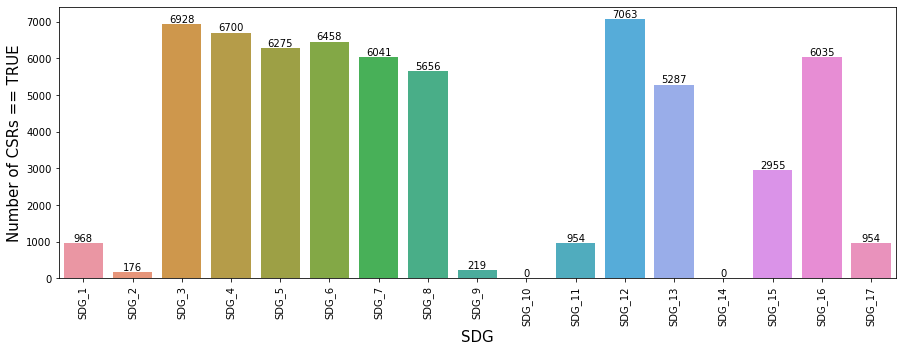

In [6]:
# TEMP
# Number of TRUE per SDG
xs = []
ys = []
for column in df.columns[9:26]:
    xs.append(column)
    ys.append(sum(df[column] == True))

plt.figure(figsize=(15,5))
ax = sns.barplot(x=xs, y=ys)
ax.bar_label(ax.containers[0])
plt.xticks(rotation=90)
plt.xlabel("SDG", fontsize=15)
plt.ylabel("Number of CSRs == TRUE", fontsize=15)
plt.show()  

## 2. Balance dataset with MLSmote (to be done)
https://www.kaggle.com/tolgadincer/upsampling-multilabel-data-with-mlsmote

In [ ]:
# Whole dataset is too large

In [237]:
# X and Y need to be dataframes for MLSmote

# Data
count_vect = CountVectorizer()
X_counts = count_vect.fit_transform(df['CSR_Text_tokenized'])

tfidf_transformer = TfidfTransformer()
X = tfidf_transformer.fit_transform(X_counts)

X = pd.DataFrame(X.toarray())

# Labels: Exclude SDGs 10 and 14
Y = df[['SDG_1', 'SDG_2', 'SDG_3', 'SDG_4', 'SDG_5', 'SDG_6', 'SDG_7', 'SDG_8', 'SDG_9', 'SDG_11', 'SDG_12', 'SDG_13', 'SDG_15', 'SDG_16', 'SDG_17']]

In [238]:
from sklearn.datasets import make_classification
from sklearn.neighbors import NearestNeighbors
import random

def get_tail_label(df: pd.DataFrame, ql=[0.05, 1.]) -> list:
    """
    Find the underrepresented targets.
    Underrepresented targets are those which are observed less than the median occurance.
    Targets beyond a quantile limit are filtered.
    """
    irlbl = df.sum(axis=0)
    irlbl = irlbl[(irlbl > irlbl.quantile(ql[0])) & ((irlbl < irlbl.quantile(ql[1])))]  # Filtering
    irlbl = irlbl.max() / irlbl
    threshold_irlbl = irlbl.median()
    tail_label = irlbl[irlbl > threshold_irlbl].index.tolist()
    return tail_label

def get_minority_samples(X: pd.DataFrame, y: pd.DataFrame, ql=[0.05, 1.]):
    """
    return
    X_sub: pandas.DataFrame, the feature vector minority dataframe
    y_sub: pandas.DataFrame, the target vector minority dataframe
    """
    tail_labels = get_tail_label(y, ql=ql)
    index = y[y[tail_labels].apply(lambda x: (x == 1).any(), axis=1)].index.tolist()
    
    X_sub = X[X.index.isin(index)].reset_index(drop = True)
    y_sub = y[y.index.isin(index)].reset_index(drop = True)
    return X_sub, y_sub

def nearest_neighbour(X: pd.DataFrame, neigh) -> list:
    """
    Give index of 10 nearest neighbor of all the instance
    
    args
    X: np.array, array whose nearest neighbor has to find
    
    return
    indices: list of list, index of 5 NN of each element in X
    """
    nbs = NearestNeighbors(n_neighbors=neigh, metric='euclidean', algorithm='kd_tree').fit(X)
    euclidean, indices = nbs.kneighbors(X)
    return indices

def MLSMOTE(X, y, n_sample, neigh=5):
    """
    Give the augmented data using MLSMOTE algorithm
    
    args
    X: pandas.DataFrame, input vector DataFrame
    y: pandas.DataFrame, feature vector dataframe
    n_sample: int, number of newly generated sample
    
    return
    new_X: pandas.DataFrame, augmented feature vector data
    target: pandas.DataFrame, augmented target vector data
    """
    indices2 = nearest_neighbour(X, neigh=5)
    n = len(indices2)
    new_X = np.zeros((n_sample, X.shape[1]))
    target = np.zeros((n_sample, y.shape[1]))
    for i in range(n_sample):
        reference = random.randint(0, n-1)
        neighbor = random.choice(indices2[reference, 1:])
        all_point = indices2[reference]
        nn_df = y[y.index.isin(all_point)]
        ser = nn_df.sum(axis = 0, skipna = True)
        target[i] = np.array([1 if val > 0 else 0 for val in ser])
        ratio = random.random()
        gap = X.loc[reference,:] - X.loc[neighbor,:]
        new_X[i] = np.array(X.loc[reference,:] + ratio * gap)
    new_X = pd.DataFrame(new_X, columns=X.columns)
    target = pd.DataFrame(target, columns=y.columns)
    return new_X, target

In [239]:
# X and Y need to be dataframes
X = pd.DataFrame(X.toarray())
Y = df[['SDG_1', 'SDG_2', 'SDG_3', 'SDG_4', 'SDG_5', 'SDG_6', 'SDG_7', 'SDG_8', 'SDG_9', 'SDG_11', 'SDG_12', 'SDG_13', 'SDG_15', 'SDG_16', 'SDG_17']]

MemoryError: Unable to allocate 20.9 GiB for an array with shape (8141, 345064) and data type float64

In [20]:
# Create synthetic samples
X_sub, y_sub = get_minority_samples(X, Y)  # Getting minority samples of that datframe
X_res, y_res = MLSMOTE(X_sub, y_sub, 1000, 5)  # Applying MLSMOTE to augment the dataframe

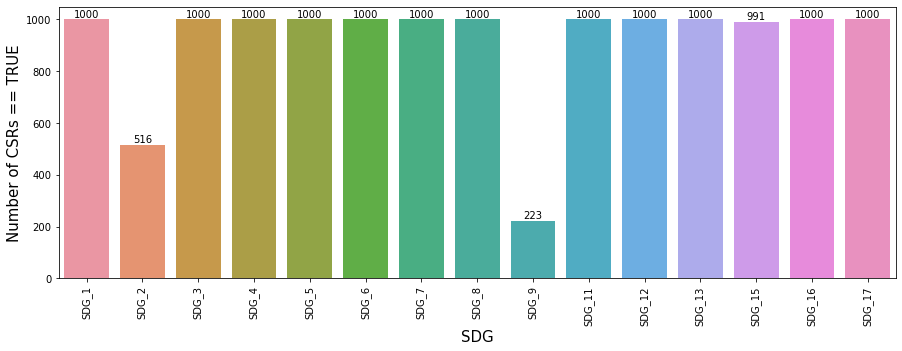

In [21]:
# Number of TRUE per SDG
xs = []
ys = []
for column in y_res.columns:
    xs.append(column)
    ys.append(sum(y_res[column] == True))

plt.figure(figsize=(15,5))
ax = sns.barplot(x=xs, y=ys)
ax.bar_label(ax.containers[0])
plt.xticks(rotation=90)
plt.xlabel("SDG", fontsize=15)
plt.ylabel("Number of CSRs == TRUE", fontsize=15)
plt.show()  

## 4. Classification

In [231]:
# Labels: Exclude SDGs 10 and 14
Y = df[['SDG_1', 'SDG_2', 'SDG_3', 'SDG_4', 'SDG_5', 'SDG_6', 'SDG_7', 'SDG_8', 'SDG_9', 'SDG_11', 'SDG_12', 'SDG_13', 'SDG_15', 'SDG_16', 'SDG_17']].to_numpy().astype(int)

# Data
count_vect = CountVectorizer()
X_counts = count_vect.fit_transform(df['CSR_Text_tokenized'])

tfidf_transformer = TfidfTransformer()
X = tfidf_transformer.fit_transform(X_counts)

In [232]:
# K-fold CV using stratified sampling

# http://scikit.ml/api/skmultilearn.model_selection.iterative_stratification.html

scores = [[],[]] # Store F1 scores
iteration_counter = 1 #  Keep track of iteration

clf_lr = OneVsRestClassifier(LogisticRegression())
clf_nb = OneVsRestClassifier(MultinomialNB())

k_fold = IterativeStratification(n_splits=2, order=1) # k-fold stratified sampling

for train, test in k_fold.split(X, Y):
    scores_counter = 0 # Keep track of scores
    print('Iteration ' + str(iteration_counter))
    
    for classifier in tqdm([clf_lr, clf_nb]): # For each classifier: Compute F1 score
        classifier.fit(X[train], Y[train])
        pred = classifier.predict(X[test])
        scores[scores_counter].append(f1_score(Y[test], pred, average='macro'))
        scores_counter += 1 
    iteration_counter += 1

print('Logistic Regression: ' + str(np.mean(scores[0])))
print('Naive Bayes: ' + str(np.mean(scores[1])))

Iteration 1


  0%|          | 0/2 [00:00<?, ?it/s]

Iteration 2


  0%|          | 0/2 [00:00<?, ?it/s]

Logistic Regression: 0.6789937965612225
Naive Bayes: 0.5220187741411866


In [233]:
# Train best-performing model using stratified sampling

# from sklearn.model_selection import train_test_split does not work:
# ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.

X_train, Y_train, X_test, Y_test = iterative_train_test_split(X, Y, test_size = 0.3)
clf_lr.fit(X_train, Y_train)
pred = clf_lr.predict(X_test)

              precision    recall  f1-score   support

           0       0.92      0.34      0.50       294
           1       0.00      0.00      0.00        46
           2       0.85      1.00      0.91      2164
           3       0.82      1.00      0.90      2093
           4       0.80      0.99      0.88      1958
           5       0.84      0.96      0.90      2009
           6       0.80      0.96      0.87      1880
           7       0.77      0.97      0.86      1783
           8       0.00      0.00      0.00        63
           9       0.90      0.33      0.48       286
          10       0.86      1.00      0.92      2202
          11       0.77      0.88      0.82      1659
          12       0.86      0.68      0.76       881
          13       0.78      0.98      0.87      1855
          14       0.90      0.33      0.48       286

   micro avg       0.81      0.93      0.87     19459
   macro avg       0.72      0.69      0.68     19459
weighted avg       0.81   

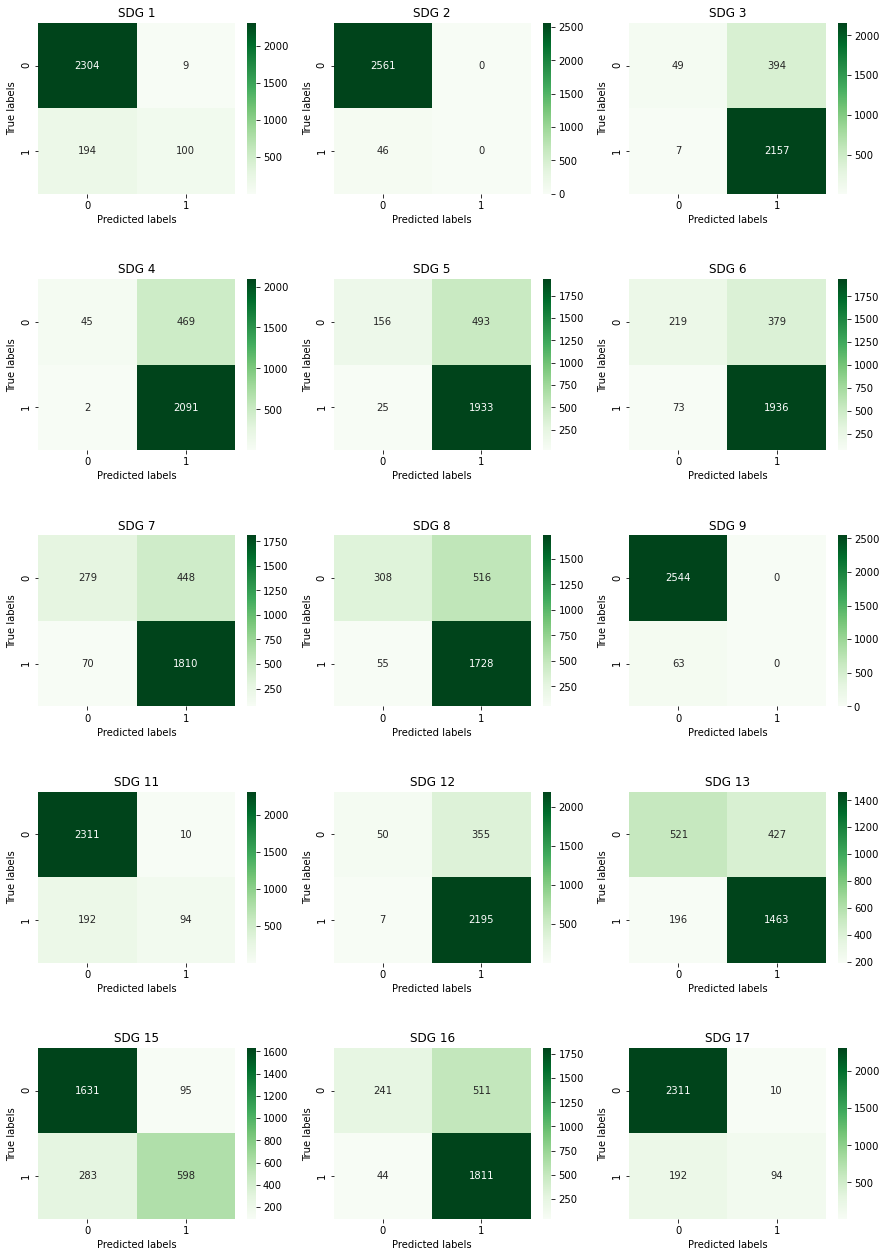

In [234]:
# Evaluation
print(classification_report(Y_test, pred))

sdgs = [1,2,3,4,5,6,7,8,9,11,12,13,15,16,17]
counter = 0
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(15,22))
plt.subplots_adjust(hspace = 0.5)
for ax in axes.flatten():
    cm = confusion_matrix(Y_test[:,counter], pred[:,counter])
    sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Greens')
    ax.set_title('SDG ' + str(sdgs[counter]))
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels') 
    counter += 1

## 5. Other stuff

In [80]:
#Hamming score for multilabel classification

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import hamming_loss

def hamming_score(y_true, y_pred, normalize=True, sample_weight=None):
    '''
    Compute the Hamming score (a.k.a. label-based accuracy) for the multi-label case
    http://stackoverflow.com/q/32239577/395857
    '''
    acc_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )
        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = len(set_true.intersection(set_pred))/float(len(set_true.union(set_pred)) )
        acc_list.append(tmp_a)
    return np.mean(acc_list)

def print_score(y_pred, clf):
    print("Clf: ", clf.__class__.__name__)
    print("Hamming loss: {}".format(hamming_loss(y_pred, y_test_tfidf)))
    print("Hamming score: {}".format(hamming_score(y_pred, y_test_tfidf)))
    print("---")    

nb_clf = MultinomialNB()
sgd = SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=42, max_iter=6, tol=None)
lr = LogisticRegression()

for classifier in [nb_clf, sgd, lr]:
    clf = OneVsRestClassifier(classifier)
    clf.fit(x_train_tfidf, y_train_tfidf)
    y_pred = clf.predict(x_test_tfidf)
    print_score(y_pred, classifier)